## Snowfall Trends Over the Siachen Glacier (1976-2025)

---

### Objective:

Analyze long-term changes in snowfall over the Siachen Glacier using gridded historical weather data from Open-Meteo.

### Method:

- Use a bounding box covering the Siachen Glacier region
- Aggregate snowfall spatially using the mean across grid cells
- Analyze yearly snowfall trends over 50 years

Data source: Open-Mateo Historical Weather API (model=era5)


In [66]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json

In [67]:
# bounding box for Siachen Glacier
LAT_MIN = 35.1667
LAT_MAX = 35.7000
LON_MIN = 76.7667
LON_MAX = 77.4167

START_DATE = "1976-01-01"
END_DATE = "2025-12-31"

RAW_DATA_PATH = Path("../data/raw/siachen_snowfall_daily_raw.json")

In [68]:
url = "https://archive-api.open-meteo.com/v1/archive"

params = {
    "bounding_box": f"{LAT_MIN},{LON_MIN},{LAT_MAX},{LON_MAX}",
    "start_date": START_DATE,
    "end_date": END_DATE,
    "daily": "snowfall_sum",
    "timezone": "UTC",
    "models": "era5",
}

response = requests.get(url, params=params, timeout=60)
response.raise_for_status()

data = response.json()

In [69]:
print(response.status_code)
print(type(data), len(data))

200
<class 'list'> 6


In [70]:
cell = data[0]
print(cell.keys())

dict_keys(['latitude', 'longitude', 'generationtime_ms', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation', 'daily_units', 'daily'])


In [71]:
# saving the raw response
RAW_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

with open(RAW_DATA_PATH, "w") as f:
    json.dump(data, f, indent=2)

print(f"Raw response successfully saved to: {RAW_DATA_PATH}")

Raw response successfully saved to: ../data/raw/siachen_snowfall_daily_raw.json


In [72]:
# confirming alignment
len(cell["daily"]["time"]), len(cell["daily"]["snowfall_sum"])

(18263, 18263)

In [74]:
df_cell = pd.DataFrame(
    {
        "date": pd.to_datetime(cell["daily"]["time"]),
        "snowfall_cm": cell["daily"]["snowfall_sum"],
    }
)
df_cell.head()

,date,snowfall_cm
0,1976-01-01,3.50
1,1976-01-02,1.47
2,1976-01-03,0.07
3,1976-01-04,0.00
4,1976-01-05,0.00


In [75]:
df_cell["latitude"] = cell["latitude"]
df_cell["longitude"] = cell["longitude"]

df_cell.tail()

,date,snowfall_cm,latitude,longitude
18258,2025-12-27,0.00,35.25,76.75
18259,2025-12-28,1.05,35.25,76.75
18260,2025-12-29,1.05,35.25,76.75
18261,2025-12-30,1.33,35.25,76.75
18262,2025-12-31,2.45,35.25,76.75


In [76]:
dfs = []

for cell in data:
    df = pd.DataFrame(
        {
            "date": pd.to_datetime(cell["daily"]["time"]),
            "snowfall_cm": cell["daily"]["snowfall_sum"],
        }
    )

    df["latitude"] = cell["latitude"]
    df["longitude"] = cell["longitude"]

    dfs.append(df)

In [77]:
snowfall_all = pd.concat(dfs, ignore_index=True)
snowfall_all.head()

,date,snowfall_cm,latitude,longitude
0,1976-01-01,3.50,35.25,76.75
1,1976-01-02,1.47,35.25,76.75
2,1976-01-03,0.07,35.25,76.75
3,1976-01-04,0.00,35.25,76.75
4,1976-01-05,0.00,35.25,76.75


In [78]:
snowfall_all["date"].nunique()

18263

In [80]:
snowfall_all.shape

(109578, 4)

In [81]:
# saving the combined time-series data of 6 spatial(cells) [csv format]
COMBINED_DATA_PATH = Path("../data/processed/combined_all_spatial_data.csv")

COMBINED_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

snowfall_all.to_csv(
    COMBINED_DATA_PATH,
    sep=",",
    index="False",
    header="True",
    encoding="utf-8-sig",
    date_format="%Y-%m-%d",
)

print(f"Successfully saved combined spatila data to : {COMBINED_DATA_PATH}")

Successfully saved combined spatila data to : ../data/processed/combined_all_spatial_data.csv


In [82]:
# spatial averaging - spatial mean of all the grids to get average of whole Siachen Glacier
# total 6 grids or 6 spatial cells for Siachen Glacier
snowfall_all.groupby("date").size().head()

date
1976-01-01    6
1976-01-02    6
1976-01-03    6
1976-01-04    6
1976-01-05    6
dtype: int64

In [83]:
spatial_mean_daily = snowfall_all.groupby("date", as_index=False).agg(
    mean_snowfall_cm=("snowfall_cm", "mean")
)

spatial_mean_daily["mean_snowfall_cm"] = spatial_mean_daily["mean_snowfall_cm"].round(2)

# row represents the average snowfall across the entier Siachen glacier on that day
spatial_mean_daily.head()

,date,mean_snowfall_cm
0,1976-01-01,3.70
1,1976-01-02,2.05
2,1976-01-03,0.35
3,1976-01-04,0.00
4,1976-01-05,0.00


In [84]:
# date range check
spatial_mean_daily["date"].min(), spatial_mean_daily["date"].max()

(Timestamp('1976-01-01 00:00:00'), Timestamp('2025-12-31 00:00:00'))

In [85]:
# distribution check

spatial_mean_daily["mean_snowfall_cm"].describe()

count    18263.000000
mean         1.008989
std          1.942485
min          0.000000
25%          0.000000
50%          0.080000
75%          1.200000
max         31.090000
Name: mean_snowfall_cm, dtype: float64

In [86]:
spatial_mean_daily.columns

Index(['date', 'mean_snowfall_cm'], dtype='str')

In [87]:
# saving the processed mean spatial data

PROCESSED_MEAN_SPATIAL_DATA_PATH = Path(
    "../data/processed/siachen_daily_spatial_mean_snowfall.csv"
)

PROCESSED_MEAN_SPATIAL_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

spatial_mean_daily.to_csv(
    PROCESSED_MEAN_SPATIAL_DATA_PATH,
    sep=",",
    index="False",
    header="True",
    encoding="utf-8-sig",
    date_format="%Y-%m-%d",
)

print(
    f"Successfully save mean spatial snowfall data in: {PROCESSED_MEAN_SPATIAL_DATA_PATH}"
)

Successfully save mean spatial snowfall data in: ../data/processed/siachen_daily_spatial_mean_snowfall.csv


In [88]:
# summing daily snowfall within each year

spatial_mean_daily["year"] = spatial_mean_daily["date"].dt.year

spatial_mean_daily.head()

,date,mean_snowfall_cm,year
0,1976-01-01,3.70,1976
1,1976-01-02,2.05,1976
2,1976-01-03,0.35,1976
3,1976-01-04,0.00,1976
4,1976-01-05,0.00,1976


In [89]:
annual_snowfall = spatial_mean_daily.groupby("year", as_index=False).agg(
    total_snowfall_cm=("mean_snowfall_cm", "sum")
)

annual_snowfall.shape

(50, 2)

In [90]:
annual_snowfall["year"].min(), annual_snowfall["year"].max()

(np.int32(1976), np.int32(2025))

In [91]:
annual_snowfall["total_snowfall_cm"].describe()

count     50.000000
mean     368.543400
std       60.521192
min      260.190000
25%      329.245000
50%      359.150000
75%      416.015000
max      503.210000
Name: total_snowfall_cm, dtype: float64

In [92]:
annual_snowfall["total_snowfall_cm"] = annual_snowfall["total_snowfall_cm"].round(2)

In [93]:
# saving the annual snowfall data in ../data/result
ANNUAL_SNOWFALL_DATA_PATH = Path("../data/result/siachen_annual_snowfall.csv")

ANNUAL_SNOWFALL_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

annual_snowfall.to_csv(
    ANNUAL_SNOWFALL_DATA_PATH,
    sep=",",
    index="False",
    header="True",
    encoding="utf-8-sig",
    date_format="%Y-%m-%d",
)

print(f"Successfully save mean spatial snowfall data in: {ANNUAL_SNOWFALL_DATA_PATH}")

Successfully save mean spatial snowfall data in: ../data/result/siachen_annual_snowfall.csv


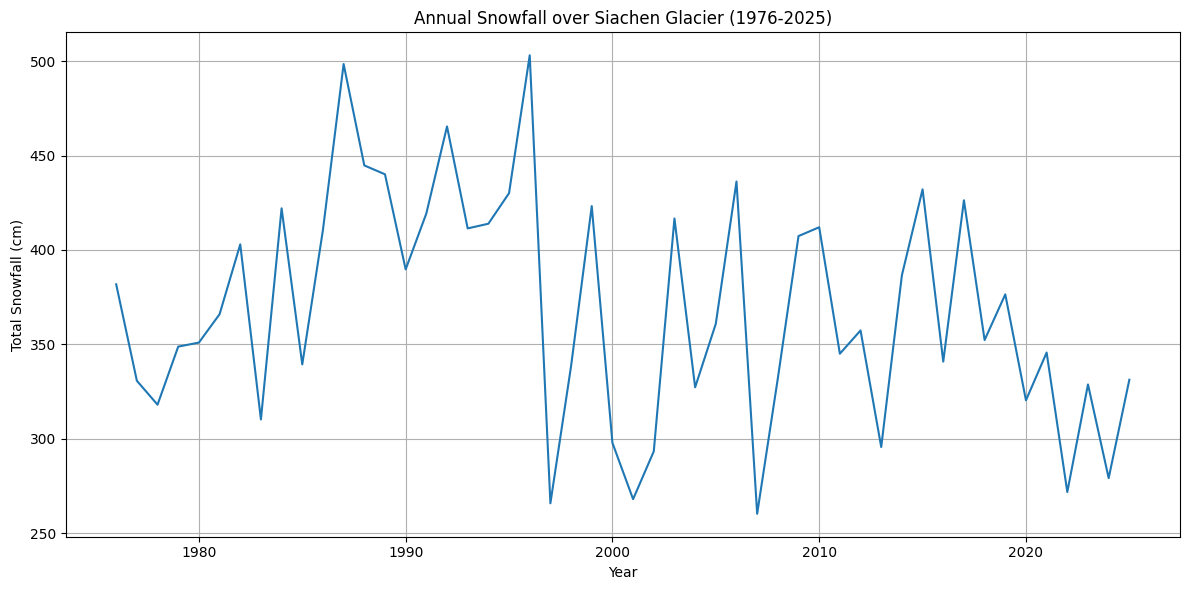

In [94]:
# visualization

plt.figure(figsize=(12, 6))
plt.plot(annual_snowfall["year"], annual_snowfall["total_snowfall_cm"])

plt.title("Annual Snowfall over Siachen Glacier (1976-2025)")
plt.xlabel("Year")
plt.ylabel("Total Snowfall (cm)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [95]:
# 5 year rolling mean

annual_snowfall["rolling_5yr_mean"] = (
    annual_snowfall["total_snowfall_cm"].rolling(window=5).mean()
)

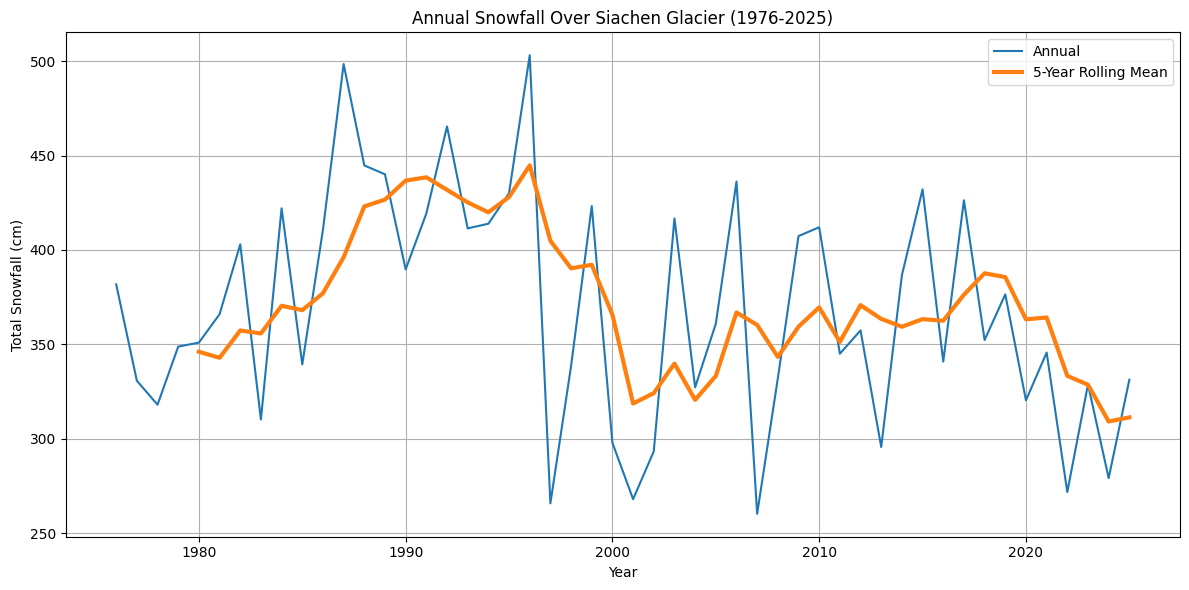

In [96]:
# plotting annual snowfall with 5 year rolling mean

plt.figure(figsize=(12, 6))

plt.plot(annual_snowfall["year"], annual_snowfall["total_snowfall_cm"], label="Annual")

plt.plot(
    annual_snowfall["year"],
    annual_snowfall["rolling_5yr_mean"],
    linewidth=3,
    label="5-Year Rolling Mean",
)

plt.title("Annual Snowfall Over Siachen Glacier (1976-2025)")
plt.xlabel("Year")
plt.ylabel("Total Snowfall (cm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()